## Appendix/Code:

### Multi-Class Identification Using Random Forests and Principal Components Analysis (PCA) Dimensionality Reduction Technique:
 - In this experiment the MNIST data set will be used. The data set contains data for tens of thousands of images for handwritten digits from 0 to 9. 
 - A classifier will be developed that can be used to predict which of the 10 digits is written.
 - The goal of this experiment is to assess the effectiveness of PCA as a preliminary to machine learning classification.
 - A random forest classifier will be fit on a model training set initially without PCA, then another random forest classifier will be built based off components identified using PCA, which will also be fit as a separate model.
 - Models will be evaluated on a test set that will be scored by a third party (Kaggle).
 - To assess the time and resources involved, total elapsed times are reported. The first model will be used as a benchmark for subsequent testing.

### Initial Setup:

#### Import Libraries:

In [75]:
#For data
import pandas as pd
# For math
import numpy as np
# For data visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from PIL import Image
import seaborn as sns
from itertools import cycle
# For modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_predict, train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score
from sklearn.metrics import average_precision_score, precision_recall_fscore_support, f1_score, precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import IncrementalPCA
from sklearn.manifold import TSNE
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
# Limiting floats output to 3 decimal points
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))
# Timer for execution time
from timeit import default_timer as timer
# Ignore warning from sklearn and seaborn
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn 
%pylab inline

Populating the interactive namespace from numpy and matplotlib


#### Define Functions: 

In [76]:
# Used to generate image of handwritten digits based on data
def plot_images(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

In [77]:
# Used to visualize clusters identified from dimensionality reduction techniques.
def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

In [78]:
# Used to visualize classification reports for better visibility
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['Precision', 'Recall', 'f1-score']
    yticks = list(np.unique(y_tru))
    yticks += ['AVG']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd))[:3,:].T
    avg = np.mean(rep, axis=0)
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    sns.heatmap(rep, annot=True, cbar=True, fmt='g', cmap='Blues', xticklabels=xticks, yticklabels=yticks, ax=ax)
    b, t = plt.ylim() # Fix cutoff
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

In [79]:
# Used for confusion matrix visualization
def plot_confusion_matrix(matrix, annot, axes, color): 
    sns.heatmap(matrix, annot=annot,ax=axes, fmt='g', cmap=color); #annot=True to annotate cells
    b, t = plt.ylim() # Fix cutoff
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    return

In [80]:
# Evaluation classifiers for accuracy scoring and f1 scoring
def evaluate_classifier_acc(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
    return accuracy_score(y_train, y_pred)

def evaluate_classifier_f1(clf, X_train, y_train):
    clf.fit(X_train, y_train)
    y_pred = cross_val_predict(clf, X_train, y_train, cv=10)
    return f1_score(y_train, y_pred, average='macro')

#### Import Data and Initial Examination:

In [81]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [82]:
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [83]:
print(train.shape, test.shape)

(42000, 785) (28000, 784)


#### Train and Test Sets for Modeling:
 - For simplicity, data remains unscaled, as random forest classifiers are scale invariant.
 - As the goal is to evaluate random forest classifiers using PCA and without using PCA, scaling is ignored, but may make a difference in real world application as PCA depends on normalized data.
 - The unscaled method used is taken from examples presented by Géron (2017) [1], and Müller et al. (2017) [2].

In [84]:
# Using unscaled data for evaluation as Random Forests are scale invariant
y_train = train['label'].values
X_train = train.drop(columns=['label'])
X_train = X_train.to_numpy()
X_test = test.to_numpy()

### Random Forest Classifier with No Decomposition:

In [85]:
# Random forest classifier with no decomposition
start = timer()
rnd_clf = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
submission = rnd_clf.predict(X_test)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1.8274822000003041


In [86]:
# Test submission
submission = pd.DataFrame(submission, columns=['Label'])
submission.index = np.arange(1,len(submission)+1)
submission.reset_index(inplace=True)
submission.rename(columns={'index':'ImageId'}, inplace=True)
submission.to_csv('submission.csv', index=False)

### Scoring Using Random Forest Classifier:
#### User Name: drew21717, User ID: 3311891, Kaggle Score: 0.94242


### Random Forest Classifier Using Principal Components Analysis (PCA):

In [88]:
# Merging Data for PCA 
merged = np.concatenate((X_train, X_test), axis=0)
print("All data size is : {}".format(merged.shape))

All data size is : (70000, 784)


In [94]:
# Principal components analysis on combined set
start = timer()
pca = PCA(n_components=0.95, random_state=1)
pca_merged = pca.fit(merged)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 7.05740650000007


In [95]:
# Number of components identified representing 95 percent of variability
pca_merged.n_components_

154

In [96]:
# Confirming that 95 percent of variability is represented
np.sum(pca_merged.explained_variance_ratio_)

0.9503499702078614

In [97]:
# Random forest classifier using PCA
start = timer()
rnd_clf1 = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
X_train_m = pca_merged.transform(X_train)
X_test_m = pca_merged.transform(X_test)
rnd_clf1.fit(X_train_m, y_train)
# Model executed on test data
submission1 = rnd_clf1.predict(X_test_m)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 3.624982399998771


In [99]:
# Data prepared for test submission
submission1 = pd.DataFrame(submission1, columns=['Label'])
submission1.index = np.arange(1,len(submission1)+1)
submission1.reset_index(inplace=True)
submission1.rename(columns={'index':'ImageId'}, inplace=True)
submission1.to_csv('submission1.csv', index=False)

### Scoring Using Random Forest Classifier and PCA Dimensionality Reduction:
#### User Name: drew21717, User ID: 3311891,  Kaggle Score: 0.88314


### Identify Major Design Flaw:
 - The major design flaw with the methods executed above was that PCA was executed on the combined training and test data set together, and then training and test sets were transformed based on the PCA. 
 - The problem with this is that training models that include test sets strongly influence whether or not the model will generalize well to new data. 
 - Even in a scenario where dimensionality reduction is employed, fitting the model (or training the model) on all the data can cause inadvertent effects on the subsequent training model, causing overfitting. Evaluating models on test data in consequence will affect reliability in such a case where dimensionality reduction is executed on both training and test set data. 
 - In other words, the idea behind a training and test set is that the test set should be unseen by the estimator until the testing stage. This means that everything that goes into building the estimator (e.g. dimensionality reduction, model fitting, tuning, and so on) has to be employed on the training set, otherwise the model will not generalize well to new data.

### Random Forest Classifier Using PCA with Major Design Flaw Fixed:
 - In the following, the major design flaw was fixed, and the experiment was rerun in a way that is consistent with a training and test regimen. 
 - Although the combined data using dimensionality reduction showed test scores that were higher, as the proper implementation of the training and test regimen shows, subsequent evaluations would show that the model does not generalize well to new data.
 - The fixed design shown below shows a significant reduction in execution time, though it is important to note that the random forest classifier that did not use dimensionality reduction performed much faster, and scored better when the model was evaluated on the test data.
 - As there is a significant difference between evaluation scores, the models will be further explored to evaluated if there were other design flaws, and if the design can be improved. 
 - Further exploration will use the the model with the major design flaw that was fixed.  

In [104]:
# Principal components analysis on training and test set
start = timer()
pca = PCA(n_components=0.95, random_state=1)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.transform(X_test)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 4.676491599999281


In [105]:
# Number of components identified representing 95 percent of variability
pca.n_components_

154

In [106]:
# Random forest classifier using PCA
np.sum(pca.explained_variance_ratio_)

0.9504332382633767

In [107]:
# Random forest classifier using PCA with design flaw Fixed
start = timer()
rnd_clf2 = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
rnd_clf2.fit(X_train_reduced, y_train)
submission2 = rnd_clf2.predict(X_test_reduced)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 2.965300300002127


In [108]:
# Data prepared for test submission
submission2 = pd.DataFrame(submission2, columns=['Label'])
submission2.index = np.arange(1,len(submission2)+1)
submission2.reset_index(inplace=True)
submission2.rename(columns={'index':'ImageId'}, inplace=True)
submission2.to_csv('submission2.csv', index=False)

### Scoring Using Random Forest Classifier and PCA Dimensionality Reduction with Design Flaw Fixed:
#### User ID: drew21717, User ID: 3311891, Kaggle Score: 0.87671

### Identify Possible Other Problems with PCA and Random Forests Using EDA:
 - Employing a Random Forest Classifier with PCA dimensionality reduction produced significantly worse results.
 - It is common for performance to drop slightly when reducing dimensionality, because some useful signal is lost in the process. However, the performance drop was severe in this case. Based on execution times, PCA did not help either. PCA will give a speedup for other algorithms, such as softmax regression, but with this case it did not.
 - In this section, PCA dimensionality reduction will be further explored to understand why results were substantially different.
 - After identification of another possible flaw, data will be retrained and retested with the flaw fixed, and results will be reported.
 - PCA will be compared with other dimensionality reduction methods to see if there are other alternatives that may provide better results.

#### PCA Defined: 
 - Principal components analysis (PCA) is a method that rotates the dataset in such a way that the rotated features are uncorrelated. The rotation is followed by selecting only a subset of new features, according to how important they are in explaining the data [2]. 
 - In an example of a two-dimensional data set, the algorithm first identifies the direction of the maximum variance, whereby it would be referred to as component 1. This is the direction where the vector contains the most information, or where the features are most correlated with each other. Then the algorithm finds the direction that contains the most information while being orthogonal to the first direction [2]. In high dimensional spaces there would be many orthogonal directions. The directions found in this process are called principal components; they are the main directions of variance in the data. 
 - In a rotated representation of principal components found by PCA in a two-dimensional data set, the two axes would be uncorrelated, or in other words, the correlation matrix of the data is zero except for the diagonal. Therefore, PCA for dimensionality reduction can be used by retaining only some of the principal components. 
 - In the example of a two-dimensional data set, PCA would reduce the set from two dimensions to one dimension while preserving the maximum amount of variance [1]. PCA selects the axis that will likely loss the least amount information as opposed to other projections. The simple idea behind PCA is that it chooses the axis that minimizes the mean squared distance between the original data set and its projection onto that axis [1].               

### Initial Visualization of Data:

#### Image Comparison Between Original and PCA Transformed Data:
 - Reverting back the PCA transformed data to the original shows that there is a difference, due to reconstruction error, yet it does not seem as significant. However, the reconstructed image shows that there is still a lost in signal using PCA. 

In [142]:
X_recovered = pca.inverse_transform(X_train_reduced) 

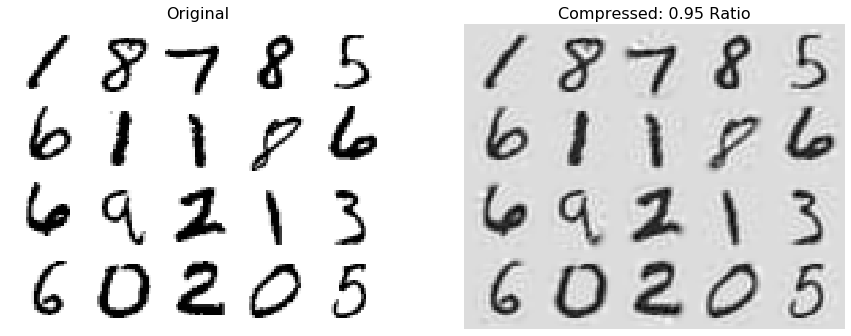

In [26]:
plt.figure(figsize=(15, 12))
plt.subplot(121)
plot_images(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_images(X_recovered[::2100])
plt.title("Compressed: 0.95 Ratio", fontsize=16)
plt.savefig("mnist_compression_plot")
plt.show();

#### PCA Visualization of Clusters Based on Two Components:
 - 2 components are used as using all components are difficult to plot.
 - Visualization shows that although there are a few clusters, there is significant overlap. Yet, this is only for two components. 
 - Therefore, by examining the visualization with only two components, PCA still seems to separate the feature space into visible clusters. It is evident that the separation will only get better as the number of components rise because PCA captures the largest amount variance with more components.  
 - However, PCA is a linear algorithm. Thus, it will not be able to interpret complex polynomial relationships between features.
 - A major problem with linear dimensionality reduction algorithms is that they concentrate on placing dissimilar data points far apart in a lower dimension representation.
 - But in order to represent high dimension data on a lower dimension, non-linear manifold, it is important that similar datapoints must be represented close together, which is not what linear dimensionality reduction algorithms do.
 - This may be a reason why the results were suboptimal, in addition to the fact that random forests split data on nonlinear points to categorize better.
 - It is important to note that unless data has the presence of high dependencies or sparsity, random forests can work well with high dimensional data. 

In [71]:
start = timer()
pca_eda = PCA(n_components=2, random_state=1)
X_reduced_2 = pca_eda.fit_transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1.2238995999978215


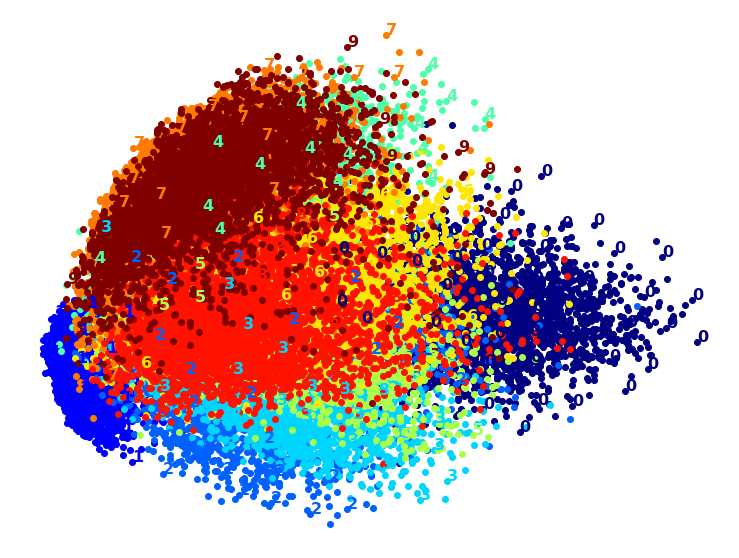

In [72]:
plot_digits(X_reduced_2, y_train)

### Evaluation Metrics and Visualizations: 
 - In the initial executions of the model there was a major design flaw. Even with the problem fixed the model did not perform any better.
 - This section focuses on evaluating the two models, and identify if there are any additional problems with the random forest classifier that used PCA.

### Classification Reports and Confusion Matrices:
 - Classification reports based on estimations using a 10-fold cross-validation strategy showed not only significant differences in accuracy, but marked differences in precision, recall, and f1 scores for classes 2 through 5, 8, and 9. 
 - Precision is basically defined as the ratio of the number of true positives over true positives plus false positives. Recall is defined as the ratio of the number of true positives over true positives plus false negatives. Essentially, precision is a measure of exactness, and recall is a measure of completeness.
 - The F1 scoring metric is a simpler way of evaluating the relationship between precision and recall. The F1 score is the harmonic mean of precision and recall. Whereas the regular mean treats values equally, the harmonic mean gives more weight to low values. Therefore, the classifier will only get a high F1 score if both the recall and precision are high [1].
 - Using PCA, although accuracy shows a score of 0.88, one of the lowest scores for precision and recall was for class 3, where it was only correct 81% of the time, and only detected 86% of 3s. In contrast, class 8 was correct 88% of the time, but had the lowest recall. It detected 8s only 77% of the time. It is evident that without PCA, precision and recall for 3s and 8s were much better. Additionally, with PCA, 8, 3, and 5 had the lowest F1 scores.
 - The confusion matrix confirms the precision and recall issue with the random forest classifier using PCA, as 3s were incorrectly predicted as 8s 103 times, and 8s were incorrectly predicted as 3s 266 times. Without PCA, the random forest classifier was incorrect 51 and 97 times, respectively. In addition, 5s were incorrectly classified as 3s 292 times with PCA compared to 147 without PCA (147 is the highest incorrect classification without PCA). The highest incorrect classification with PCA were 310 incorrectly classified 4s that were actually 9.    

#### Classification Report on Random Forest Classifier with No Decomposition:

In [115]:
# Ten fold cross validation estimator on random forest classification with no decomposition
y_pred = cross_val_predict(rnd_clf, X_train, y_train, cv=10)

In [116]:
# Classification report on random forest classification with no decomposition using cross validated prediction data
print('Classification Report with No Decomposition:')
print(metrics.classification_report(y_train, y_pred), '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred))

Classification Report with No Decomposition:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97      4132
           1       0.97      0.98      0.98      4684
           2       0.93      0.95      0.94      4177
           3       0.91      0.92      0.92      4351
           4       0.93      0.95      0.94      4072
           5       0.92      0.91      0.92      3795
           6       0.96      0.96      0.96      4137
           7       0.96      0.95      0.95      4401
           8       0.94      0.89      0.91      4063
           9       0.93      0.91      0.92      4188

    accuracy                           0.94     42000
   macro avg       0.94      0.94      0.94     42000
weighted avg       0.94      0.94      0.94     42000
 

Confusion Matrix:
[[4056    0    8   11    4    8   19    2   22    2]
 [   0 4605   23   13   11    4    7    9   11    1]
 [  36   17 3963   32   21    7   20   35   40    6]
 [  17   16   86 

#### Classification Report on Random Forest Classifier Using PCA:

In [112]:
# Ten fold cross validation estimator on random forest classification using PCA
y_pred2 = cross_val_predict(rnd_clf2, X_train_reduced, y_train, cv=10)

In [156]:
# Classification report on random forest classification using PCA with cross validated prediction data
print('Classification Report with PCA Dimensionality Reduction:')
print(metrics.classification_report(y_train, y_pred2), '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred2))

Classification Report with PCA Dimensionality Reduction:
              precision    recall  f1-score   support

           0       0.88      0.95      0.92      4132
           1       0.96      0.97      0.97      4684
           2       0.84      0.89      0.86      4177
           3       0.81      0.86      0.84      4351
           4       0.84      0.89      0.87      4072
           5       0.84      0.80      0.82      3795
           6       0.94      0.92      0.93      4137
           7       0.92      0.89      0.90      4401
           8       0.88      0.77      0.82      4063
           9       0.88      0.82      0.85      4188

    accuracy                           0.88     42000
   macro avg       0.88      0.88      0.88     42000
weighted avg       0.88      0.88      0.88     42000
 

Confusion Matrix:
[[3935    2   31   30   11   32   45    6   30   10]
 [  15 4552   42   19    7    9    7    8   20    5]
 [  84   21 3710   87   52   19   41   49   90   24]
 [  6

#### Classification Report Heat Maps:
 - Heatmaps show how the two are on completely different scales. With PCA the scale goes as lower than 0.80.

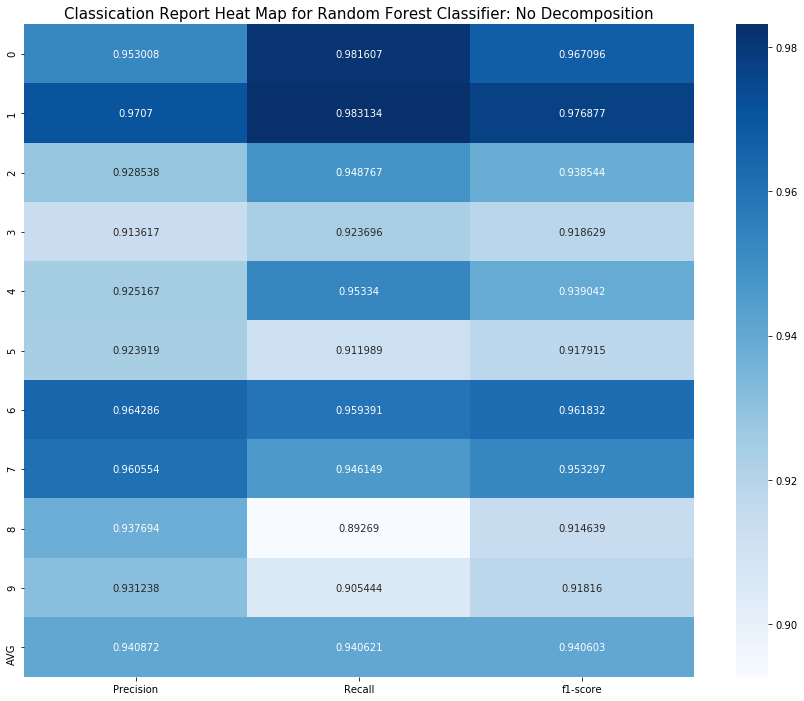

In [117]:
#Random Forest with No Decomposition
plot_classification_report(y_train, y_pred, (15,12))
plt.title('Classication Report Heat Map for Random Forest Classifier: No Decomposition', fontsize=15)
plt.savefig('Classication Report Heat Map with No Decomposition: Random Forest Classifier')
plt.show();

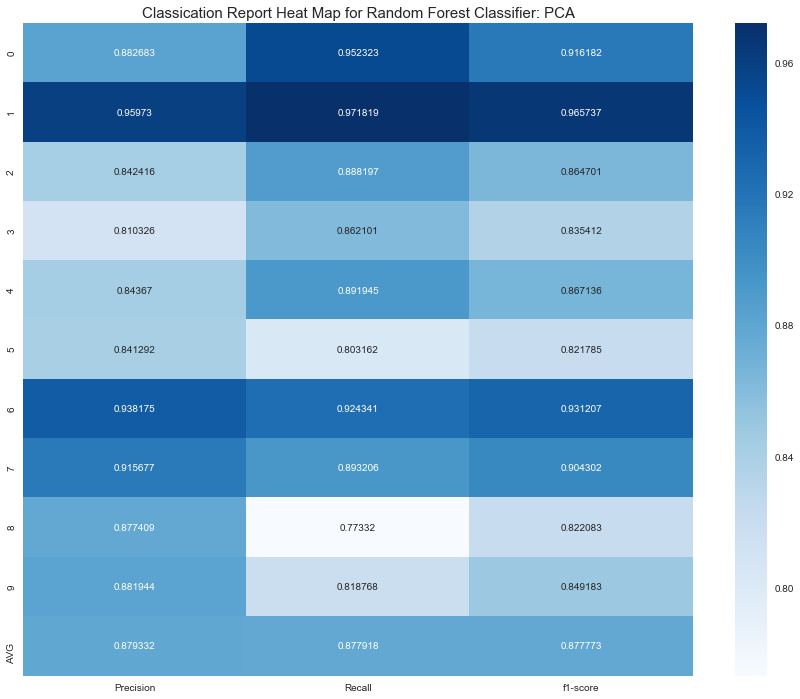

In [420]:
#Random Forest Using PCA
plot_classification_report(y_train, y_pred2, (15,12))
plt.title('Classication Report Heat Map for Random Forest Classifier: PCA', fontsize=15)
plt.savefig('Classication Report Heat Map for Random Forest Classifier PCA')
plt.show();

#### Confusion and Error Matrix Visualization:
 - Some of the darkest colors showing the performance issues were classifications for 5, 8, and 9. The darker colors for 8 and 9 with PCA are consistent with the low F1 scores. 
 - The errors matrix shows the scale of errors, the highest without using PCA being around 3.9% and 7.7% with using PCA (both being 3s that were actually 5s).
 - In the random forest classifier using PCA, 9s being confused as 4s were also substantially higher. 

#### Confusion Matrix Plot:

In [149]:
#Confusion Matrix
conf_mx1 = confusion_matrix(y_train, y_pred)
conf_mx2 = confusion_matrix(y_train, y_pred2)

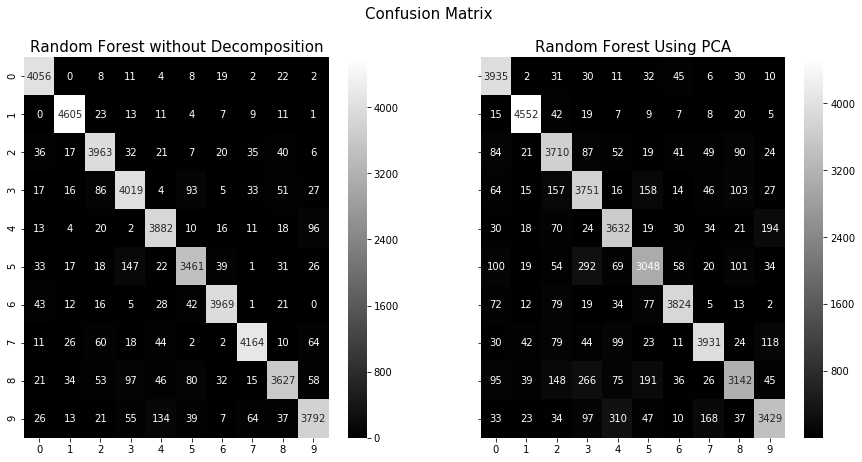

In [151]:
#Confusion Matrix Plot
f,(ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))
g1 = plot_confusion_matrix(conf_mx1, True, ax1, 'gray')
ax1.set_title('Random Forest without Decomposition', fontsize=15)
g2 = plot_confusion_matrix(conf_mx2, True, ax2, 'gray')
ax2.set_title('Random Forest Using PCA', fontsize=15)
plt.suptitle('Confusion Matrix', fontsize=15)
plt.savefig('confusion matrix rfr pca no pca')
plt.show();

#### Errors Matrix:

In [123]:
#Error Computations
#No decomposition
row_sums1 = conf_mx1.sum(axis=1, keepdims=True)
norm_conf_mx1 = conf_mx1 / row_sums1
np.fill_diagonal(norm_conf_mx1, 0)
#PCA
row_sums2 = conf_mx2.sum(axis=1, keepdims=True)
norm_conf_mx2 = conf_mx2 / row_sums2
np.fill_diagonal(norm_conf_mx2, 0)

In [130]:
# Random Forest Classifier without PCA
pd.DataFrame(norm_conf_mx1).describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.005,0.003,0.007,0.009,0.008,0.007,0.004,0.004,0.006,0.007
std,0.004,0.003,0.006,0.013,0.009,0.008,0.003,0.005,0.004,0.008
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.003,0.001,0.004,0.002,0.001,0.001,0.001,0.000,0.003,0.000
50%,0.005,0.003,0.005,0.003,0.005,0.002,0.003,0.002,0.005,0.004
75%,0.008,0.004,0.011,0.012,0.009,0.010,0.005,0.007,0.009,0.012
max,0.010,0.008,0.020,0.039,0.032,0.021,0.010,0.015,0.012,0.024


In [131]:
# Random Forest Classifier with PCA
pd.DataFrame(norm_conf_mx2).describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.013,0.005,0.017,0.022,0.016,0.014,0.006,0.009,0.011,0.011
std,0.009,0.003,0.012,0.027,0.022,0.016,0.005,0.012,0.010,0.015
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.007,0.003,0.008,0.005,0.003,0.005,0.002,0.002,0.004,0.001
50%,0.011,0.005,0.016,0.009,0.010,0.006,0.005,0.006,0.006,0.006
75%,0.019,0.005,0.019,0.023,0.018,0.017,0.010,0.010,0.018,0.011
max,0.026,0.010,0.036,0.077,0.074,0.047,0.015,0.040,0.027,0.048


#### Confusion Matrix Errors Plot:

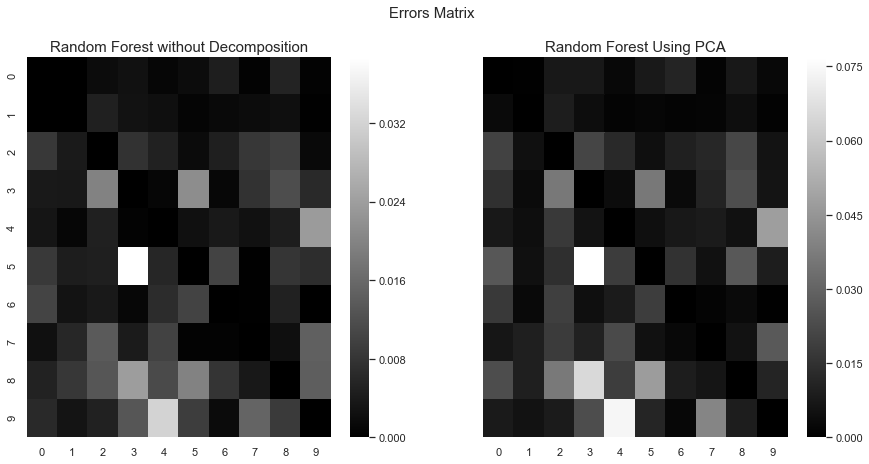

In [184]:
#Confusion matrix errors plot
f,(ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))
g1 = plot_confusion_matrix(norm_conf_mx1, False, ax1, 'gray')
ax1.set_title('Random Forest without Decomposition', fontsize=15)
g2 = plot_confusion_matrix(norm_conf_mx2, False, ax2, 'gray')
ax2.set_title('Random Forest Using PCA', fontsize=15)
plt.suptitle('Errors Matrix', fontsize=15)
plt.savefig('confusion errors rfr pca no pca')
plt.show();

### Multi-Class Precision-Recall and ROC Curves:
 - Training data was split 50/50 into a training set and test set, and a 10-fold cross-validation probability estimation was performed. This was evaluated with the test set.
 - Precision-Recall curves show a significant difference, especially for class identifications from 2 through 5, 8, and 9, when a random forest classifier is used with PCA.
 - ROC curves show representations of high AUC scores for both models, indicating that there is good separability, however confusion matrices showed that there were significant false positives.
 - Therefore, the precision-recall curves are better to examine as they make it clear that the random forest classifier using PCA has room for improvement.
 - The random forest classifier that did not use PCA showed most curves reaching for the top-right most corner. The classifier that used PCA showed a number of curves that need improvement, the greatest being 5, 8, and 9. 
 - For class 5 using PCA, to compete with the precision of the random forest classifier that did not use PCA, recall would have to be reduced to around 0.50, which would reduce the F1 score to around 0.70. Therefore, to be correct 90% of the time, it would have to detect class 5 50% of the time, which is a terrible tradeoff.   

#### Precision-Recall Curve: Random Forest with No Decomposition:

In [388]:
# Binarize data for multi-class plotting for random forest classifier with no decomposition

y_bin = label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9]) 
n_classes = y_bin.shape[1]

X_train_bin_r, X_test_bin_r, y_train_bin_r, y_test_bin_r = train_test_split(X_train, y_bin, test_size=.5, random_state=1)

classifier_r = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, max_features='sqrt', 
                                                        bootstrap=True, random_state=1, n_jobs=-1))

classifier_r.fit(X_train_bin_r, y_train_bin_r)
y_score_r = cross_val_predict(classifier_r, X_test_bin_r, y_test_bin_r, cv=10, method='predict_proba')

In [389]:
#Setup for multi-class precision recall curve
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin_r[:, i],
                                                        y_score_r[:, i])
    average_precision[i] = average_precision_score(y_test_bin_r[:, i], y_score_r[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin_r.ravel(),
    y_score_r.ravel())
average_precision["micro"] = average_precision_score(y_test_bin_r, y_score_r,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.96


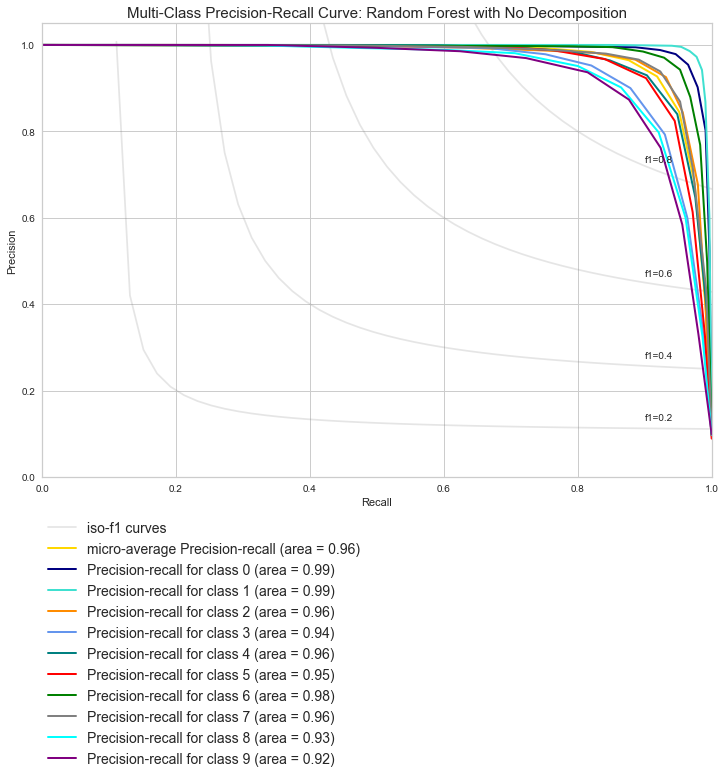

In [390]:
# Multi-class precision recall plot
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'gray', 'aqua', 'purple'])

plt.figure(figsize=(12, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve: Random Forest with No Decomposition', fontsize=15)
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=14))
plt.savefig('Multi-Class Precision-Recall Curve: Random Forest with No Decompostion')

plt.show();

#### ROC Curve: Random Forest with No Decomposition:

In [391]:
#Setup for multi-class ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin_r[:, i], y_score_r[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin_r.ravel(), y_score_r.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

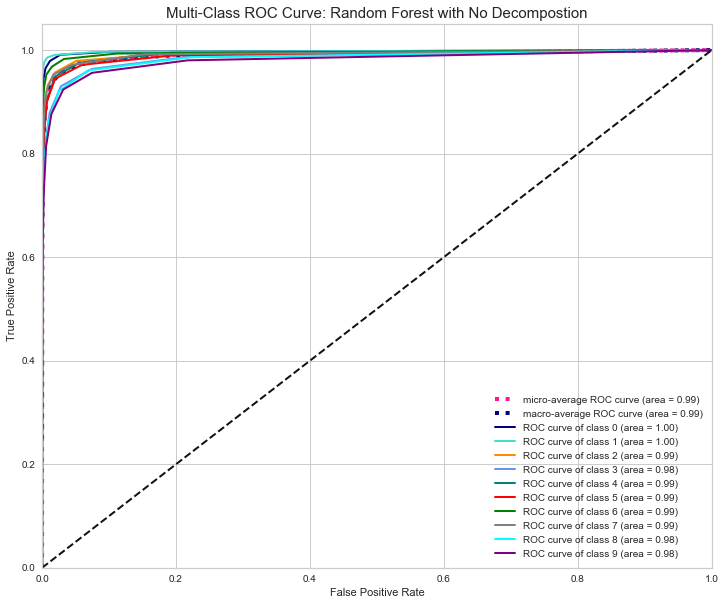

In [392]:
# Multi-class ROC curve plot
lw=2
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'gray', 'aqua', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve: Random Forest with No Decompostion', fontsize=15)
plt.legend(loc="lower right")
plt.savefig('Multi-Class ROC Curve: Random Forest No Decomposition');
plt.show();

#### Precision-Recall Curve: Random Forest Using PCA:

In [366]:
# Binarize data for multi-class plotting for random forest classifier using PCA
y_bin = label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9]) 
n_classes = y_bin.shape[1]

X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(X_train_reduced, y_bin, test_size=.5, random_state=1)

classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, max_features='sqrt', 
                                                        bootstrap=True, random_state=1, n_jobs=-1))

classifier.fit(X_train_bin, y_train_bin)
y_score = cross_val_predict(classifier, X_test_bin, y_test_bin, cv=10, method='predict_proba')

In [369]:
#Setup for multi-class precision recall curve
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test_bin, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.88


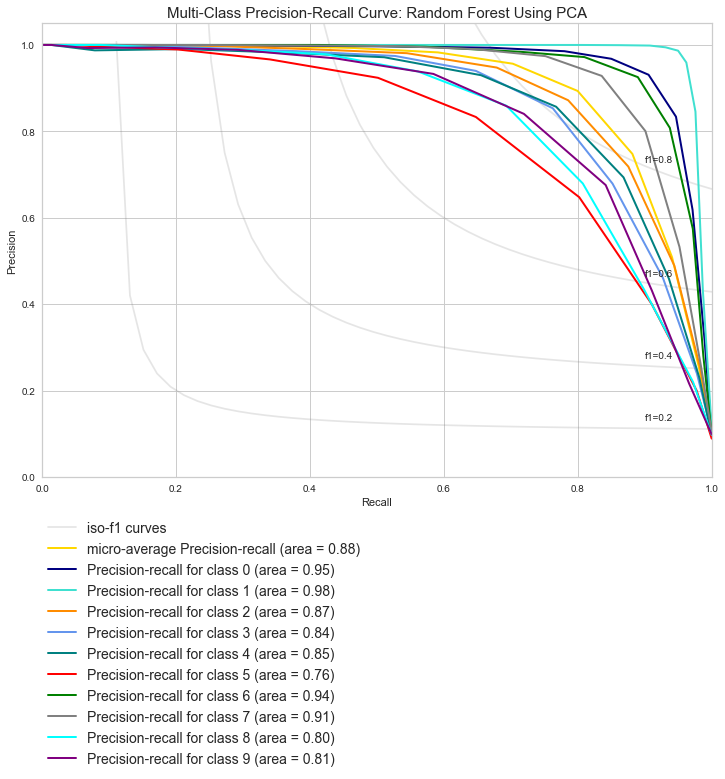

In [384]:
# Multi-class precision recall plot
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'gray', 'aqua', 'purple'])

plt.figure(figsize=(12, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve: Random Forest Using PCA', fontsize=15)
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=14))
plt.savefig('Multi-Class Precision-Recall Curve: Random Forest Using PCA')

plt.show();

#### ROC Curve: Random Forest Using PCA:

In [367]:
#Setup for multi-class ROC curve
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

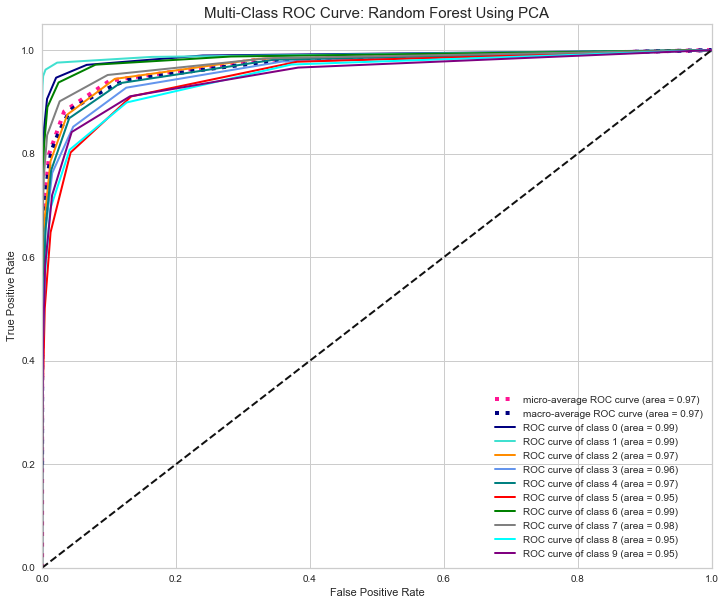

In [386]:
# Multi-class ROC curve plot
from itertools import cycle
lw=2
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(12, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'gray', 'aqua', 'purple'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve: Random Forest Using PCA', fontsize=15)
plt.legend(loc="lower right")
plt.savefig('Multi-Class ROC Curve: Random Forest Using PCA');
plt.show();

### Visualizations Comparing Variance, Accuracy, and F1 for Random Forests Using Different PCA Components:
 - Visualizations show that while the explained variance ratio rises as there are more components, accuracy and f1 scores drop when using a random forest classifier.
 - Although utilizing more components preserves the maximum amount of variance, which is supposed to keep as much information as possible, a higher explained variance ratio seems to work against the random forest classifier that was employed. 
 - Therefore, a higher explained variance ratio seems to produce an overfitting model when utilizing a random forest classifier with PCA in this case.
 - Th F1 score, a single measure that trades off precision versus recall by showing the weighted harmonic mean (meaning that it gives more weight to low values), shows that the drop indicates that both the average precision and recall become lower as components rise. As examined in the multi-class precision-recall curves and the classification report, this is largely due to significant misclassification from classes 2 through 5, and 8 and 9. This was also evident when observing the error matrix as there is a marked increase in false positives and negatives for these same classes.
 - As PCA simply looks for correlations in the data and combines the most correlated features into principal components while separating uncorrelated ones, it serves as an automated version of feature selection or extraction. Therefore, it seems that increasing components at a certain point works negatively in a random forest scenario, in addition to the fact that variance is redistributed among new variables in the most “unequal” way: the first variable not only explains the most variance among the new variables, but the most variance a single variable can possibly explain. It seems that with increasing components at a certain point, PCA may be "throwing away" essential features that are important for classification.  
 - The graphs below show that the random forest classifier works best when components are in the range of 25 to 50 components in this scenario. Variance ratios range from around 0.70 to 0.80, respectively. 
 - At its peak around 25 components, scores show a similar accuracy and F1 score to the random forest model that was employed with no dimensionality reduction. 
 - As we are using a model where PCA that was not normalized, this could have influenced the results negatively.
 - The following section will test the random forest classifier using PCA with a lowered explained variance ratio.

In [139]:
n_components_array=([1,2,3,4,5,10,20,50,154,200])
vr = np.zeros(len(n_components_array))
i=0;
for n_components in n_components_array:
    pca_plot = PCA(n_components=n_components, random_state=1)
    pca_plot.fit(X_train)
    vr[i] = sum(pca_plot.explained_variance_ratio_)
    i=i+1 

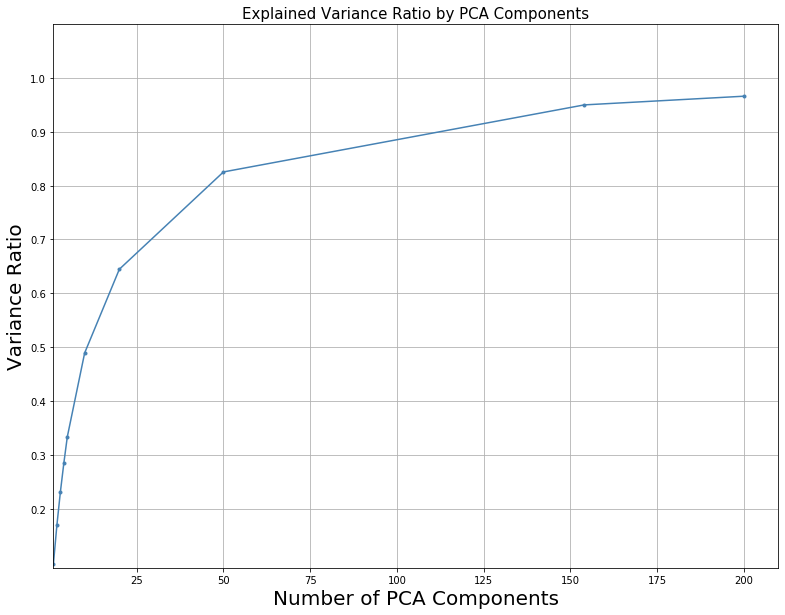

In [140]:
figure(figsize(13,10))
plot(n_components_array,vr,'k.-', color='steelblue')
ylim(9e-2,1.1)
yticks(linspace(0.2,1.0,9))
xlim(0.9)
grid(which='both')
xlabel('Number of PCA Components', size=20)
ylabel('Variance Ratio',size=20)
plt.title('Explained Variance Ratio by PCA Components', fontsize=15)
plt.savefig('Variance Ratio by PCA Components')
plt.show();

In [319]:
eval_rnd_clf_acc = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
n_components_array=([1,2,3,4,5,10,20,50,75,100,125,154,200])
score_array_acc = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca_acc = PCA(n_components=n_components, random_state=1)
    pca_acc.fit(X_train)
    transform = pca_acc.transform(X_train)
    score_array_acc[i] = evaluate_classifier_acc(eval_rnd_clf_acc, transform, y_train)
    i=i+1

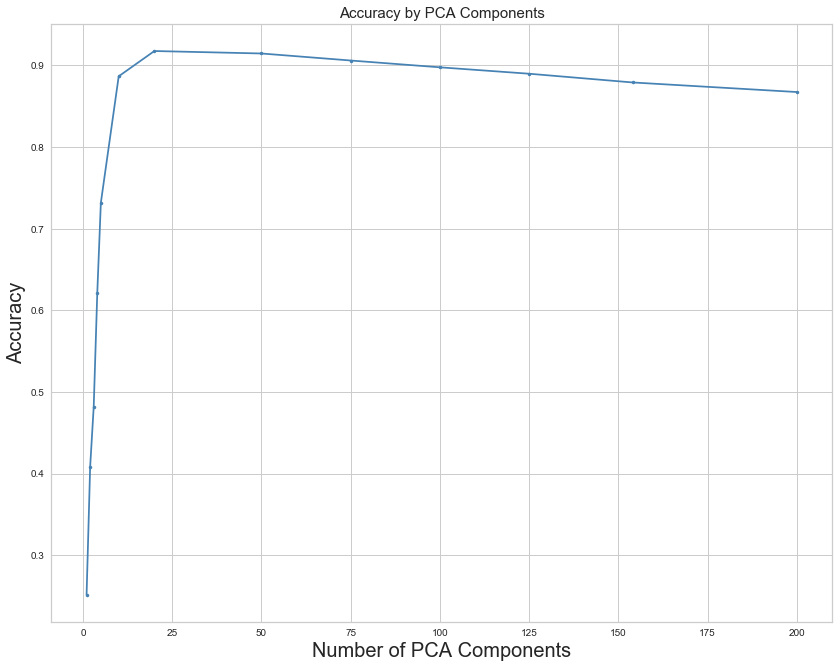

In [323]:
figure(figsize(14, 11))
plot(n_components_array, score_array_acc,'k.-', color='steelblue')
xlabel('Number of PCA Components', size=20)
ylabel('Accuracy', size=20)
grid(which='minor')
plt.title('Accuracy by PCA Components', fontsize=15)
plt.savefig('Accuracy by PCA Components')
plt.show();

In [118]:
eval_rnd_clf_f1 = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
n_components_array=([1,2,3,4,5,10,20,50,75,100,125,154,200])
score_array_f1 = np.zeros(len(n_components_array))
i=0

for n_components in n_components_array:
    pca_f1 = PCA(n_components=n_components, random_state=1)
    pca_f1.fit(X_train)
    transform = pca_f1.transform(X_train)
    score_array_f1[i] = evaluate_classifier_f1(eval_rnd_clf_f1, transform, y_train)
    i=i+1

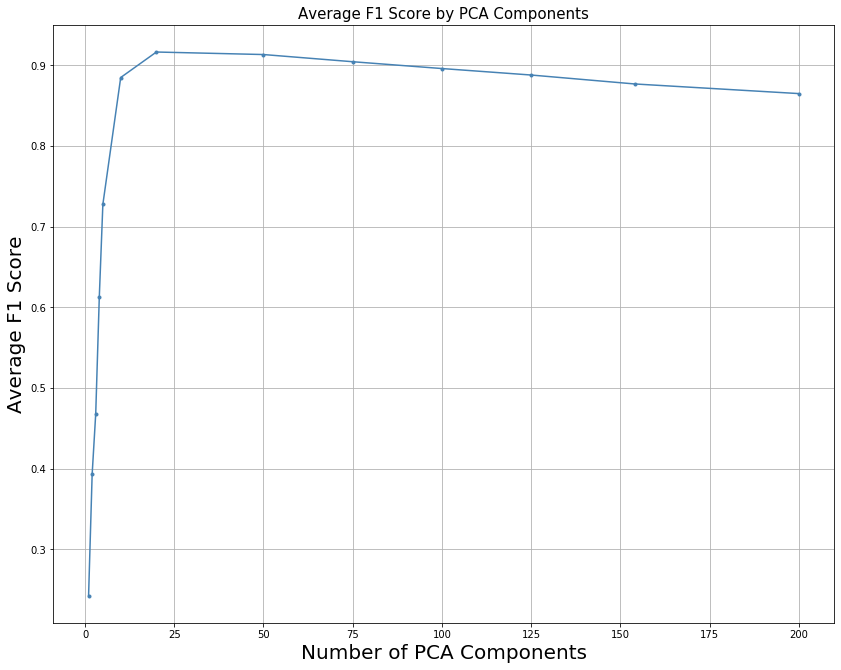

In [120]:
figure(figsize(14, 11))
plot(n_components_array, score_array_f1,'k.-', color='steelblue')
xlabel('Number of PCA Components', size=20)
ylabel('Average F1 Score', size=20)
grid(which='both')
plt.title('Average F1 Score by PCA Components', fontsize=15)
plt.savefig('F1 by PCA Components')
plt.show();

### Using Gridsearch to Find Best Principal Components Parameter for Random Forest Classifier Using PCA:
 - Using grid search, with a 10-fold cross-validation, results showed that using 27 principal components are the most optimal when applying PCA to a random forest classifier in this experiment. 
 - The explained variance ratio with 27 principal components is 0.7098.
 - Accuracy score without additional cross-validation is 0.9985.

In [8]:
pca_pipe = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=1)),
    ('rfc', RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)),
])

In [9]:
pca_pipe.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('pca',
                 PCA(copy=True, iterated_power='auto', n_components=0.95,
                     random_state=1, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('rfc',
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='sqrt',
                                        max_leaf_nodes=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=10, n_jobs=-1,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_sta

In [56]:
param_grid = dict(pca__n_components=range(1, 154))
grid_clf = GridSearchCV(pca_pipe, param_grid, cv=10, verbose=2)
grid_clf.fit(X_train, y_train)

Fitting 10 folds for each of 153 candidates, totalling 1530 fits
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .............................. pca__n_components=1, total=   4.3s
[CV] pca__n_components=1 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.3s remaining:    0.0s


[CV] .............................. pca__n_components=1, total=   2.4s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   2.4s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   2.4s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   2.4s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   2.5s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   2.3s
[CV] pca__n_components=1 .............................................
[CV] .............................. pca__n_components=1, total=   2.3s
[CV] pca__n_components=1 .............................................
[CV] .

[CV] .............................. pca__n_components=6, total=   2.4s
[CV] pca__n_components=7 .............................................
[CV] .............................. pca__n_components=7, total=   2.4s
[CV] pca__n_components=7 .............................................
[CV] .............................. pca__n_components=7, total=   2.3s
[CV] pca__n_components=7 .............................................
[CV] .............................. pca__n_components=7, total=   2.4s
[CV] pca__n_components=7 .............................................
[CV] .............................. pca__n_components=7, total=   2.4s
[CV] pca__n_components=7 .............................................
[CV] .............................. pca__n_components=7, total=   2.5s
[CV] pca__n_components=7 .............................................
[CV] .............................. pca__n_components=7, total=   2.4s
[CV] pca__n_components=7 .............................................
[CV] .

[CV] ............................. pca__n_components=12, total=   2.6s
[CV] pca__n_components=12 ............................................
[CV] ............................. pca__n_components=12, total=   2.6s
[CV] pca__n_components=12 ............................................
[CV] ............................. pca__n_components=12, total=   2.6s
[CV] pca__n_components=13 ............................................
[CV] ............................. pca__n_components=13, total=   2.7s
[CV] pca__n_components=13 ............................................
[CV] ............................. pca__n_components=13, total=   2.7s
[CV] pca__n_components=13 ............................................
[CV] ............................. pca__n_components=13, total=   2.7s
[CV] pca__n_components=13 ............................................
[CV] ............................. pca__n_components=13, total=   2.7s
[CV] pca__n_components=13 ............................................
[CV] .

[CV] ............................. pca__n_components=18, total=   3.0s
[CV] pca__n_components=18 ............................................
[CV] ............................. pca__n_components=18, total=   2.9s
[CV] pca__n_components=18 ............................................
[CV] ............................. pca__n_components=18, total=   2.9s
[CV] pca__n_components=18 ............................................
[CV] ............................. pca__n_components=18, total=   2.9s
[CV] pca__n_components=18 ............................................
[CV] ............................. pca__n_components=18, total=   2.9s
[CV] pca__n_components=19 ............................................
[CV] ............................. pca__n_components=19, total=   3.2s
[CV] pca__n_components=19 ............................................
[CV] ............................. pca__n_components=19, total=   3.0s
[CV] pca__n_components=19 ............................................
[CV] .

[CV] ............................. pca__n_components=24, total=   3.1s
[CV] pca__n_components=24 ............................................
[CV] ............................. pca__n_components=24, total=   3.2s
[CV] pca__n_components=24 ............................................
[CV] ............................. pca__n_components=24, total=   3.1s
[CV] pca__n_components=24 ............................................
[CV] ............................. pca__n_components=24, total=   3.1s
[CV] pca__n_components=24 ............................................
[CV] ............................. pca__n_components=24, total=   3.1s
[CV] pca__n_components=24 ............................................
[CV] ............................. pca__n_components=24, total=   3.1s
[CV] pca__n_components=24 ............................................
[CV] ............................. pca__n_components=24, total=   3.1s
[CV] pca__n_components=25 ............................................
[CV] .

[CV] ............................. pca__n_components=30, total=   4.0s
[CV] pca__n_components=30 ............................................
[CV] ............................. pca__n_components=30, total=   3.8s
[CV] pca__n_components=30 ............................................
[CV] ............................. pca__n_components=30, total=   3.9s
[CV] pca__n_components=30 ............................................
[CV] ............................. pca__n_components=30, total=   4.0s
[CV] pca__n_components=30 ............................................
[CV] ............................. pca__n_components=30, total=   3.7s
[CV] pca__n_components=30 ............................................
[CV] ............................. pca__n_components=30, total=   3.7s
[CV] pca__n_components=30 ............................................
[CV] ............................. pca__n_components=30, total=   3.8s
[CV] pca__n_components=30 ............................................
[CV] .

[CV] ............................. pca__n_components=35, total=   3.8s
[CV] pca__n_components=36 ............................................
[CV] ............................. pca__n_components=36, total=   6.2s
[CV] pca__n_components=36 ............................................
[CV] ............................. pca__n_components=36, total=   4.3s
[CV] pca__n_components=36 ............................................
[CV] ............................. pca__n_components=36, total=   4.2s
[CV] pca__n_components=36 ............................................
[CV] ............................. pca__n_components=36, total=   4.0s
[CV] pca__n_components=36 ............................................
[CV] ............................. pca__n_components=36, total=   4.2s
[CV] pca__n_components=36 ............................................
[CV] ............................. pca__n_components=36, total=   3.9s
[CV] pca__n_components=36 ............................................
[CV] .

[CV] ............................. pca__n_components=41, total=   4.6s
[CV] pca__n_components=41 ............................................
[CV] ............................. pca__n_components=41, total=   4.7s
[CV] pca__n_components=41 ............................................
[CV] ............................. pca__n_components=41, total=   4.5s
[CV] pca__n_components=42 ............................................
[CV] ............................. pca__n_components=42, total=   4.2s
[CV] pca__n_components=42 ............................................
[CV] ............................. pca__n_components=42, total=   4.3s
[CV] pca__n_components=42 ............................................
[CV] ............................. pca__n_components=42, total=   4.6s
[CV] pca__n_components=42 ............................................
[CV] ............................. pca__n_components=42, total=   5.9s
[CV] pca__n_components=42 ............................................
[CV] .

[CV] ............................. pca__n_components=47, total=   4.7s
[CV] pca__n_components=47 ............................................
[CV] ............................. pca__n_components=47, total=   4.5s
[CV] pca__n_components=47 ............................................
[CV] ............................. pca__n_components=47, total=   4.9s
[CV] pca__n_components=47 ............................................
[CV] ............................. pca__n_components=47, total=   4.5s
[CV] pca__n_components=47 ............................................
[CV] ............................. pca__n_components=47, total=   4.4s
[CV] pca__n_components=48 ............................................
[CV] ............................. pca__n_components=48, total=   4.9s
[CV] pca__n_components=48 ............................................
[CV] ............................. pca__n_components=48, total=   4.7s
[CV] pca__n_components=48 ............................................
[CV] .

[CV] ............................. pca__n_components=53, total=   5.5s
[CV] pca__n_components=53 ............................................
[CV] ............................. pca__n_components=53, total=   5.7s
[CV] pca__n_components=53 ............................................
[CV] ............................. pca__n_components=53, total=   5.2s
[CV] pca__n_components=53 ............................................
[CV] ............................. pca__n_components=53, total=   5.3s
[CV] pca__n_components=53 ............................................
[CV] ............................. pca__n_components=53, total=   5.8s
[CV] pca__n_components=53 ............................................
[CV] ............................. pca__n_components=53, total=   5.3s
[CV] pca__n_components=53 ............................................
[CV] ............................. pca__n_components=53, total=   5.5s
[CV] pca__n_components=54 ............................................
[CV] .

[CV] ............................. pca__n_components=59, total=   5.6s
[CV] pca__n_components=59 ............................................
[CV] ............................. pca__n_components=59, total=   7.2s
[CV] pca__n_components=59 ............................................
[CV] ............................. pca__n_components=59, total=   5.2s
[CV] pca__n_components=59 ............................................
[CV] ............................. pca__n_components=59, total=   5.6s
[CV] pca__n_components=59 ............................................
[CV] ............................. pca__n_components=59, total=   5.5s
[CV] pca__n_components=59 ............................................
[CV] ............................. pca__n_components=59, total=   5.2s
[CV] pca__n_components=59 ............................................
[CV] ............................. pca__n_components=59, total=   5.8s
[CV] pca__n_components=59 ............................................
[CV] .

[CV] ............................. pca__n_components=64, total=   5.4s
[CV] pca__n_components=65 ............................................
[CV] ............................. pca__n_components=65, total=   5.6s
[CV] pca__n_components=65 ............................................
[CV] ............................. pca__n_components=65, total=   5.6s
[CV] pca__n_components=65 ............................................
[CV] ............................. pca__n_components=65, total=   5.7s
[CV] pca__n_components=65 ............................................
[CV] ............................. pca__n_components=65, total=   5.3s
[CV] pca__n_components=65 ............................................
[CV] ............................. pca__n_components=65, total=   5.5s
[CV] pca__n_components=65 ............................................
[CV] ............................. pca__n_components=65, total=   5.6s
[CV] pca__n_components=65 ............................................
[CV] .

[CV] ............................. pca__n_components=70, total=   5.5s
[CV] pca__n_components=70 ............................................
[CV] ............................. pca__n_components=70, total=   5.5s
[CV] pca__n_components=70 ............................................
[CV] ............................. pca__n_components=70, total=   5.6s
[CV] pca__n_components=71 ............................................
[CV] ............................. pca__n_components=71, total=   5.8s
[CV] pca__n_components=71 ............................................
[CV] ............................. pca__n_components=71, total=   5.7s
[CV] pca__n_components=71 ............................................
[CV] ............................. pca__n_components=71, total=   5.4s
[CV] pca__n_components=71 ............................................
[CV] ............................. pca__n_components=71, total=   5.4s
[CV] pca__n_components=71 ............................................
[CV] .

[CV] ............................. pca__n_components=76, total=   5.9s
[CV] pca__n_components=76 ............................................
[CV] ............................. pca__n_components=76, total=   6.1s
[CV] pca__n_components=76 ............................................
[CV] ............................. pca__n_components=76, total=   6.0s
[CV] pca__n_components=76 ............................................
[CV] ............................. pca__n_components=76, total=   5.8s
[CV] pca__n_components=76 ............................................
[CV] ............................. pca__n_components=76, total=   5.8s
[CV] pca__n_components=77 ............................................
[CV] ............................. pca__n_components=77, total=   5.9s
[CV] pca__n_components=77 ............................................
[CV] ............................. pca__n_components=77, total=   6.1s
[CV] pca__n_components=77 ............................................
[CV] .

[CV] ............................. pca__n_components=82, total=   5.2s
[CV] pca__n_components=82 ............................................
[CV] ............................. pca__n_components=82, total=   4.8s
[CV] pca__n_components=82 ............................................
[CV] ............................. pca__n_components=82, total=   5.0s
[CV] pca__n_components=82 ............................................
[CV] ............................. pca__n_components=82, total=   5.0s
[CV] pca__n_components=82 ............................................
[CV] ............................. pca__n_components=82, total=   5.3s
[CV] pca__n_components=82 ............................................
[CV] ............................. pca__n_components=82, total=   5.2s
[CV] pca__n_components=82 ............................................
[CV] ............................. pca__n_components=82, total=   5.2s
[CV] pca__n_components=83 ............................................
[CV] .

[CV] ............................. pca__n_components=88, total=   4.9s
[CV] pca__n_components=88 ............................................
[CV] ............................. pca__n_components=88, total=   4.8s
[CV] pca__n_components=88 ............................................
[CV] ............................. pca__n_components=88, total=   4.8s
[CV] pca__n_components=88 ............................................
[CV] ............................. pca__n_components=88, total=   4.8s
[CV] pca__n_components=88 ............................................
[CV] ............................. pca__n_components=88, total=   4.7s
[CV] pca__n_components=88 ............................................
[CV] ............................. pca__n_components=88, total=   4.7s
[CV] pca__n_components=88 ............................................
[CV] ............................. pca__n_components=88, total=   4.8s
[CV] pca__n_components=88 ............................................
[CV] .

[CV] ............................. pca__n_components=93, total=   4.8s
[CV] pca__n_components=94 ............................................
[CV] ............................. pca__n_components=94, total=   4.8s
[CV] pca__n_components=94 ............................................
[CV] ............................. pca__n_components=94, total=   4.8s
[CV] pca__n_components=94 ............................................
[CV] ............................. pca__n_components=94, total=   4.9s
[CV] pca__n_components=94 ............................................
[CV] ............................. pca__n_components=94, total=   4.9s
[CV] pca__n_components=94 ............................................
[CV] ............................. pca__n_components=94, total=   4.8s
[CV] pca__n_components=94 ............................................
[CV] ............................. pca__n_components=94, total=   4.8s
[CV] pca__n_components=94 ............................................
[CV] .

[CV] ............................. pca__n_components=99, total=   5.0s
[CV] pca__n_components=99 ............................................
[CV] ............................. pca__n_components=99, total=   5.0s
[CV] pca__n_components=99 ............................................
[CV] ............................. pca__n_components=99, total=   4.9s
[CV] pca__n_components=100 ...........................................
[CV] ............................ pca__n_components=100, total=   6.1s
[CV] pca__n_components=100 ...........................................
[CV] ............................ pca__n_components=100, total=   6.4s
[CV] pca__n_components=100 ...........................................
[CV] ............................ pca__n_components=100, total=   6.0s
[CV] pca__n_components=100 ...........................................
[CV] ............................ pca__n_components=100, total=   6.1s
[CV] pca__n_components=100 ...........................................
[CV] .

[CV] ............................ pca__n_components=105, total=   5.5s
[CV] pca__n_components=105 ...........................................
[CV] ............................ pca__n_components=105, total=   5.4s
[CV] pca__n_components=105 ...........................................
[CV] ............................ pca__n_components=105, total=   5.4s
[CV] pca__n_components=105 ...........................................
[CV] ............................ pca__n_components=105, total=   5.5s
[CV] pca__n_components=105 ...........................................
[CV] ............................ pca__n_components=105, total=   5.4s
[CV] pca__n_components=106 ...........................................
[CV] ............................ pca__n_components=106, total=   5.3s
[CV] pca__n_components=106 ...........................................
[CV] ............................ pca__n_components=106, total=   5.3s
[CV] pca__n_components=106 ...........................................
[CV] .

[CV] ............................ pca__n_components=111, total=   5.3s
[CV] pca__n_components=111 ...........................................
[CV] ............................ pca__n_components=111, total=   5.3s
[CV] pca__n_components=111 ...........................................
[CV] ............................ pca__n_components=111, total=   5.3s
[CV] pca__n_components=111 ...........................................
[CV] ............................ pca__n_components=111, total=   5.3s
[CV] pca__n_components=111 ...........................................
[CV] ............................ pca__n_components=111, total=   5.4s
[CV] pca__n_components=111 ...........................................
[CV] ............................ pca__n_components=111, total=   5.3s
[CV] pca__n_components=111 ...........................................
[CV] ............................ pca__n_components=111, total=   5.3s
[CV] pca__n_components=112 ...........................................
[CV] .

[CV] ............................ pca__n_components=117, total=   5.4s
[CV] pca__n_components=117 ...........................................
[CV] ............................ pca__n_components=117, total=   5.4s
[CV] pca__n_components=117 ...........................................
[CV] ............................ pca__n_components=117, total=   5.4s
[CV] pca__n_components=117 ...........................................
[CV] ............................ pca__n_components=117, total=   5.4s
[CV] pca__n_components=117 ...........................................
[CV] ............................ pca__n_components=117, total=   5.5s
[CV] pca__n_components=117 ...........................................
[CV] ............................ pca__n_components=117, total=   5.4s
[CV] pca__n_components=117 ...........................................
[CV] ............................ pca__n_components=117, total=   5.6s
[CV] pca__n_components=117 ...........................................
[CV] .

[CV] ............................ pca__n_components=122, total=   5.7s
[CV] pca__n_components=123 ...........................................
[CV] ............................ pca__n_components=123, total=   5.7s
[CV] pca__n_components=123 ...........................................
[CV] ............................ pca__n_components=123, total=   5.8s
[CV] pca__n_components=123 ...........................................
[CV] ............................ pca__n_components=123, total=   5.7s
[CV] pca__n_components=123 ...........................................
[CV] ............................ pca__n_components=123, total=   5.7s
[CV] pca__n_components=123 ...........................................
[CV] ............................ pca__n_components=123, total=   5.7s
[CV] pca__n_components=123 ...........................................
[CV] ............................ pca__n_components=123, total=   5.7s
[CV] pca__n_components=123 ...........................................
[CV] .

[CV] ............................ pca__n_components=128, total=   6.0s
[CV] pca__n_components=128 ...........................................
[CV] ............................ pca__n_components=128, total=   6.0s
[CV] pca__n_components=128 ...........................................
[CV] ............................ pca__n_components=128, total=   5.8s
[CV] pca__n_components=129 ...........................................
[CV] ............................ pca__n_components=129, total=   6.1s
[CV] pca__n_components=129 ...........................................
[CV] ............................ pca__n_components=129, total=   5.8s
[CV] pca__n_components=129 ...........................................
[CV] ............................ pca__n_components=129, total=   6.0s
[CV] pca__n_components=129 ...........................................
[CV] ............................ pca__n_components=129, total=   5.8s
[CV] pca__n_components=129 ...........................................
[CV] .

[CV] ............................ pca__n_components=134, total=   6.4s
[CV] pca__n_components=134 ...........................................
[CV] ............................ pca__n_components=134, total=   6.6s
[CV] pca__n_components=134 ...........................................
[CV] ............................ pca__n_components=134, total=   6.2s
[CV] pca__n_components=134 ...........................................
[CV] ............................ pca__n_components=134, total=   6.2s
[CV] pca__n_components=134 ...........................................
[CV] ............................ pca__n_components=134, total=   6.2s
[CV] pca__n_components=135 ...........................................
[CV] ............................ pca__n_components=135, total=   6.1s
[CV] pca__n_components=135 ...........................................
[CV] ............................ pca__n_components=135, total=   6.1s
[CV] pca__n_components=135 ...........................................
[CV] .

[CV] ............................ pca__n_components=140, total=   8.3s
[CV] pca__n_components=140 ...........................................
[CV] ............................ pca__n_components=140, total=   8.7s
[CV] pca__n_components=140 ...........................................
[CV] ............................ pca__n_components=140, total=   8.7s
[CV] pca__n_components=140 ...........................................
[CV] ............................ pca__n_components=140, total=   8.4s
[CV] pca__n_components=140 ...........................................
[CV] ............................ pca__n_components=140, total=   7.3s
[CV] pca__n_components=140 ...........................................
[CV] ............................ pca__n_components=140, total=   7.0s
[CV] pca__n_components=140 ...........................................
[CV] ............................ pca__n_components=140, total=   7.3s
[CV] pca__n_components=141 ...........................................
[CV] .

[CV] ............................ pca__n_components=146, total=   8.1s
[CV] pca__n_components=146 ...........................................
[CV] ............................ pca__n_components=146, total=   7.7s
[CV] pca__n_components=146 ...........................................
[CV] ............................ pca__n_components=146, total=   7.0s
[CV] pca__n_components=146 ...........................................
[CV] ............................ pca__n_components=146, total=   6.9s
[CV] pca__n_components=146 ...........................................
[CV] ............................ pca__n_components=146, total=   6.9s
[CV] pca__n_components=146 ...........................................
[CV] ............................ pca__n_components=146, total=   8.7s
[CV] pca__n_components=146 ...........................................
[CV] ............................ pca__n_components=146, total=   9.7s
[CV] pca__n_components=146 ...........................................
[CV] .

[CV] ............................ pca__n_components=151, total=   7.7s
[CV] pca__n_components=152 ...........................................
[CV] ............................ pca__n_components=152, total=  10.1s
[CV] pca__n_components=152 ...........................................
[CV] ............................ pca__n_components=152, total=   8.5s
[CV] pca__n_components=152 ...........................................
[CV] ............................ pca__n_components=152, total=   9.2s
[CV] pca__n_components=152 ...........................................
[CV] ............................ pca__n_components=152, total=   7.0s
[CV] pca__n_components=152 ...........................................
[CV] ............................ pca__n_components=152, total=   7.1s
[CV] pca__n_components=152 ...........................................
[CV] ............................ pca__n_components=152, total=   7.1s
[CV] pca__n_components=152 ...........................................
[CV] .

[Parallel(n_jobs=1)]: Done 1530 out of 1530 | elapsed: 130.9min finished


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=0.95, random_state=1,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('rfc',
                                        RandomForestClassifier(bootstrap=True,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='sqrt',
                                                               max_leaf_nodes=None,
                              

In [57]:
grid_clf.best_params_

{'pca__n_components': 27}

In [58]:
grid_clf.score(X_train, y_train)

0.9985238095238095

#### As the Test Data Needs to Be Transformed for Evaluation, Model Process is Redone with Best Parameters for Test Submission:
 - Though execution time is much smaller with less components, the random forest classifier with no dimensionality reduction is still faster.  

In [133]:
# PCA with 27 components with 0.0798 Variance Ratio
start = timer()
pca_best = PCA(n_components=27, random_state=1)
X_train_best = pca_best.fit_transform(X_train)
X_test_best = pca_best.transform(X_test)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 2.1363918999995803


In [134]:
# Check explained variance ratio 
np.sum(pca_best.explained_variance_ratio_)

0.7098038631523467

In [135]:
# Random forest classifier using PCA with variance raio at 0.0798
start = timer()
rnd_clf3 = RandomForestClassifier(n_estimators=10, max_features='sqrt', bootstrap=True, random_state=1, n_jobs=-1)
rnd_clf3.fit(X_train_best, y_train)
submission3 = rnd_clf3.predict(X_test_best)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1.2904268999991473


#### Other PCA Methods with Execution Times Reported:
 - Though Randomized PCA is the fastest, it is only slightly faster than vanilla PCA.

Incremental PCA:

In [426]:
start = timer()
n_batches = 100
inc_pca = IncrementalPCA(n_components=27)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced_inc = inc_pca.transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 8.79287640000257


In [427]:
np.sum(inc_pca.explained_variance_ratio_)

0.7086868846978569

Randomized PCA:

In [430]:
start = timer()
rnd_pca = PCA(n_components=27, random_state=1, svd_solver="randomized")
X_reduced_rnd = rnd_pca.fit_transform(X_train)
X_test_reduced_rnd = rnd_pca.transform(X_test)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 2.0231018000049517


In [431]:
np.sum(rnd_pca.explained_variance_ratio_)

0.7098038631523467

### Comparison of Random Forest Classifier Using PCA with Explained Variance Ratio at 0.7098 and PCA with Explained Variance Ratio at 0.95:

#### Image Reconstruction:
 - Image reconstruction shows a lot of visibility is lost when using a lower variance ratio. The 8s are almost indiscernable.
 - However, analysis in this section shows that the random forest classifier using PCA with a lower explained variance ratio performed significantly better and faster than with an explained variance ratio of 0.95. 
 - A 10 fold cross-validation test on predictions showed an accuracy score of 0.92. A much bigger improvement from the previous 0.88, and it is very close to the random forest classifier score of 0.94 that did not used PCA.  

In [141]:
X_recovered2 = pca_best.inverse_transform(X_train_best) 

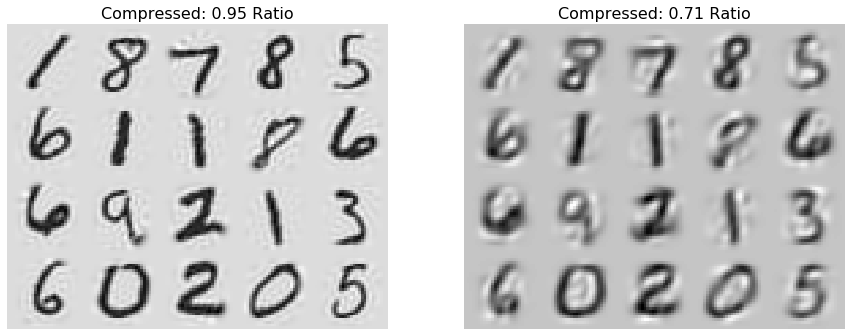

In [144]:
plt.figure(figsize=(15, 12))
plt.subplot(121)
plot_images(X_recovered[::2100])
plt.title("Compressed: 0.95 Ratio", fontsize=16)
plt.subplot(122)
plot_images(X_recovered2[::2100])
plt.title("Compressed: 0.71 Ratio", fontsize=16)
plt.savefig("mnist_compression_plot_27")
plt.show();

#### Classification Report:
 - Classification reports based on estimations using a 10 fold cross-validation strategy showed a significant improvement when using a 0.7098 explained variance ratio, especially in classes 2 through 5, 8, and 9, when compared to using an explained variance ratio of 0.95.
 - Class 3 showed the highest improvement, as the previous precision, recall, and F1 scores showed 0.81, 0.86, and 0.84, with the reduction of the explained variance ratio to 0.7098, scores went up to 0.89, 0.90, and 0.90, respectively. This means that classifications of 3s were correct 89% of the time, and detected them 90% of the time. 
 - 8s showed a marked improvement as recall went up 9%, pushing the F1 score to 89%.
 - In contrast to the image reconstruction shown previously, correct classifications between 8s and 3s have evidently improved, though difficult to distinguish in the image.
 - It seems that even with the reduction in the explained variance ratio, the reduced number of components were able to capture some of the most important features that were needed for the random forest classifier to perform effectively. 

In [136]:
y_pred3 = cross_val_predict(rnd_clf3, X_train_best, y_train, cv=10)

In [155]:
print('Classification Report with PCA (Reduced Variance Ratio to 0.7098):')
print(metrics.classification_report(y_train, y_pred3), '\n')
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_train, y_pred3))

Classification Report with PCA (Reduced Variance Ratio to 0.7098):
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      4132
           1       0.97      0.98      0.97      4684
           2       0.90      0.93      0.91      4177
           3       0.89      0.90      0.90      4351
           4       0.89      0.92      0.91      4072
           5       0.90      0.89      0.89      3795
           6       0.95      0.95      0.95      4137
           7       0.94      0.93      0.93      4401
           8       0.91      0.86      0.89      4063
           9       0.90      0.86      0.88      4188

    accuracy                           0.92     42000
   macro avg       0.92      0.92      0.92     42000
weighted avg       0.92      0.92      0.92     42000
 

Confusion Matrix:
[[4004    0   19   22    7   16   38    4   16    6]
 [   2 4577   35   17    6   12    8   10   14    3]
 [  34   15 3879   52   34    8   30   39   64  

#### Classification Report Heat Map:

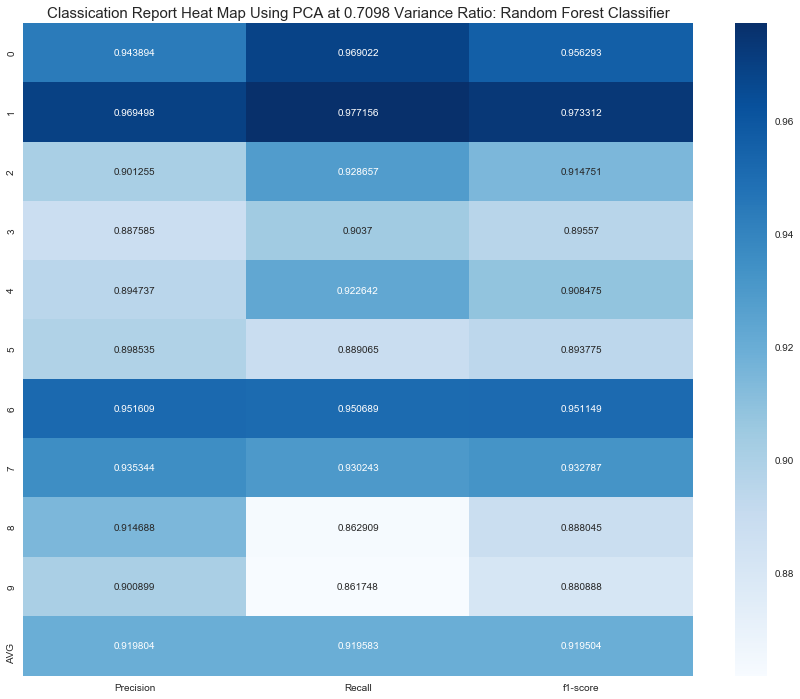

In [400]:
plot_classification_report(y_train, y_pred3, (15,12))
plt.title('Classication Report Heat Map Using PCA at 0.7098 Variance Ratio: Random Forest Classifier', fontsize=15)
plt.savefig('Classication Report Heat Map for PCA 7098 Variance Ratio')
plt.show();

#### PCA Confusion Matrix Visualization: 0.95 Variance Ratio Versus 0.7098 Variance Ratio:
 - The confusion matrix confirms that there was significant improvement, as 8s that were confused as 3s were reduced by about 41%, and 5s that were confused as 3s were reduced over 50%.
 - However, the issue that still remained were 4s, 7s, and 9s, as the reduction in incorrect classifications were not by much. 

In [146]:
conf_mx3 = confusion_matrix(y_train, y_pred3)

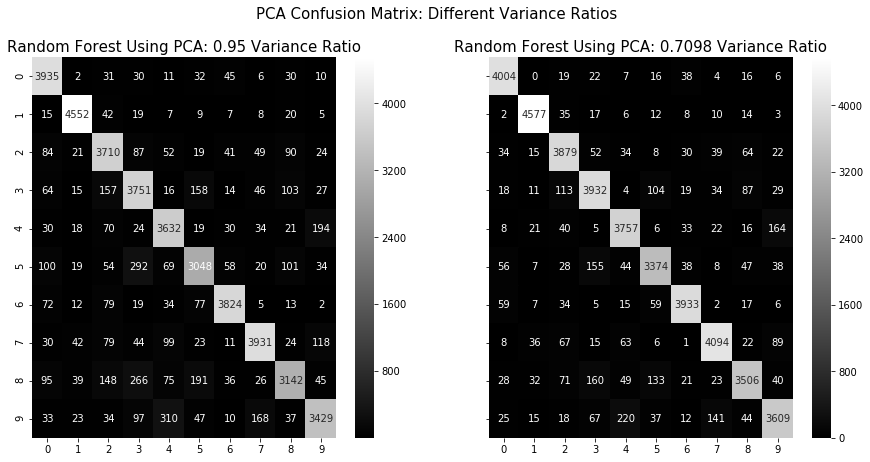

In [153]:
#Confusion Matrix Plot
f,(ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))
g3 = plot_confusion_matrix(conf_mx2, True, ax1, 'gray')
ax1.set_title('Random Forest Using PCA: 0.95 Variance Ratio', fontsize=15)
g4 = plot_confusion_matrix(conf_mx3, True, ax2, 'gray')
ax2.set_title('Random Forest Using PCA: 0.7098 Variance Ratio', fontsize=15)
plt.suptitle('PCA Confusion Matrix: Different Variance Ratios', fontsize=15)
plt.savefig('confusion matrix rfr pca diff var 07098')
plt.show();

#### PCA Errors Matrix Visualization: 0.95 Variance Ratio Versus 0.7098 Variance Ratio:
 - The errors matrix is significantly different as well. The highest error rate for PCA with a explained variance ratio of  0.7098 was 5.3%. However, the error rate was for class 4 instead of 3, which was the highest for the random forest classifier using PCA with an explained variance ratio of 0.95. 
 - This is understandable as there was not a significant improvement in 9s that were confused as 4s. Yet, an error rate that is 2.9% less is commendable.
 - In addition, the errors matrix plot also reflects the substantial improvement in 3s being correctly classified as 3s instead of 5s, which is reflected by the darker coloration.

In [147]:
row_sums3 = conf_mx3.sum(axis=1, keepdims=True)
norm_conf_mx3 = conf_mx3 / row_sums3
np.fill_diagonal(norm_conf_mx3, 0)

In [148]:
# PCA Errors Matrix Table at 0.7098 explained variance ratio
pd.DataFrame(norm_conf_mx3).describe()

,0,1,2,3,4,5,6,7,8,9
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,0.006,0.003,0.010,0.012,0.011,0.009,0.005,0.007,0.008,0.010
std,0.005,0.003,0.008,0.015,0.016,0.011,0.004,0.010,0.006,0.012
min,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.002,0.002,0.005,0.002,0.001,0.002,0.002,0.001,0.004,0.001
50%,0.005,0.003,0.008,0.004,0.006,0.003,0.005,0.004,0.005,0.006
75%,0.008,0.005,0.014,0.015,0.012,0.013,0.008,0.007,0.012,0.010
max,0.015,0.008,0.026,0.041,0.053,0.033,0.010,0.034,0.020,0.040


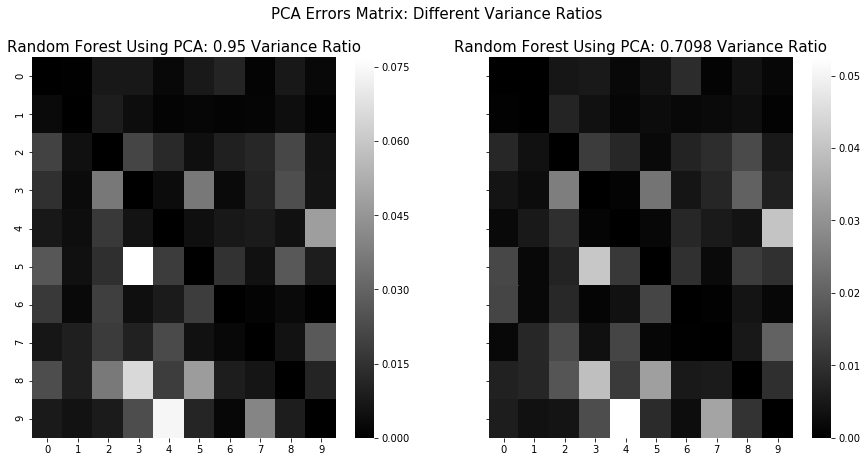

In [154]:
#Confusion matrix errors plot
f,(ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,7))
g5 = plot_confusion_matrix(norm_conf_mx2, False, ax1, 'gray')
ax1.set_title('Random Forest Using PCA: 0.95 Variance Ratio', fontsize=15)
g6 = plot_confusion_matrix(norm_conf_mx3, False, ax2, 'gray')
ax2.set_title('Random Forest Using PCA: 0.7098 Variance Ratio', fontsize=15)
plt.suptitle('PCA Errors Matrix: Different Variance Ratios', fontsize=15)
plt.savefig('confusion errors errors variance ratio pca')
plt.show();

#### Precision-Recall Curve: Random Forest Using PCA with Variance Ratio at 0.7098:
 - ROC curve was not plotted, as it is presumed that the resulting curve would be similar to the previous plots.
 - Precision-recall curve showed a significant improvement for class 5, which is not surprising given the results examined in the confusion and errors matrices.  
 - As well as class 5, classes 2 through 4, 8, and 9 showed remarkable improvement.
 - Out of all the classes, class 8 shows signs that in can be improved. This was also evident in the confusion matrix, as the misclassifications of 3s between 8s can be improved.
 - The improved precision-recall curve still pales in comparison to the random forest classifier that does not use PCA, yet all curves still tend to reach for the top right corner, indicating that there is a good tradeoff.

In [415]:
# Binarize data for multi-class plotting for random forest classifier with no decomposition

y_bin = label_binarize(y_train, classes=[0,1,2,3,4,5,6,7,8,9]) 
n_classes = y_bin.shape[1]

X_train_bin_v, X_test_bin_v, y_train_bin_v, y_test_bin_v = train_test_split(X_train_best, y_bin, 
                                                                            test_size=.5, random_state=1)

classifier_v = OneVsRestClassifier(RandomForestClassifier(n_estimators=10, max_features='sqrt', 
                                                        bootstrap=True, random_state=1, n_jobs=-1))

classifier_v.fit(X_train_bin_v, y_train_bin_v)
y_score_v = cross_val_predict(classifier_v, X_test_bin_v, y_test_bin_v, cv=10, method='predict_proba')

In [416]:
#Setup for multi-class precision recall curve
# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin_v[:, i],
                                                        y_score_v[:, i])
    average_precision[i] = average_precision_score(y_test_bin_v[:, i], y_score_v[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test_bin_v.ravel(),
    y_score_v.ravel())
average_precision["micro"] = average_precision_score(y_test_bin_v, y_score_v,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.94


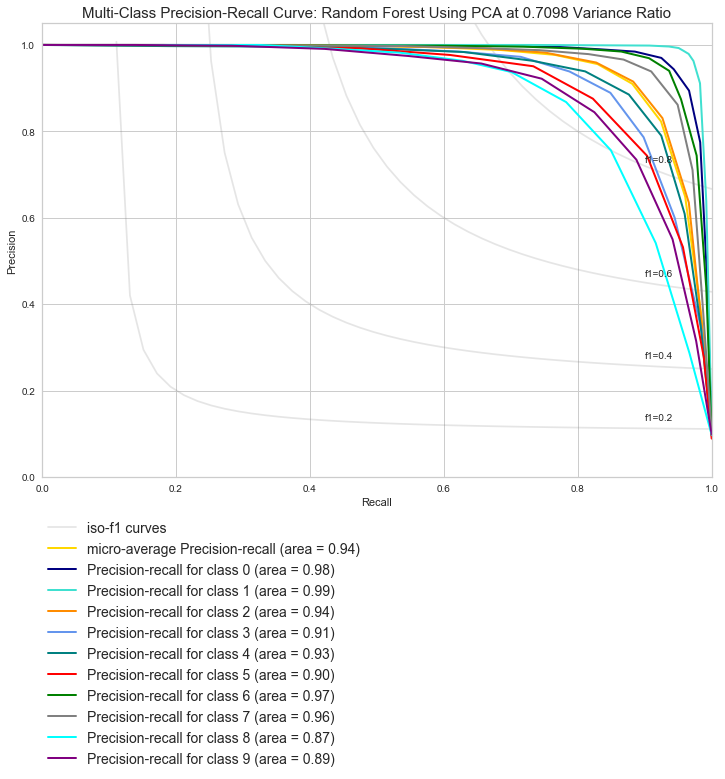

In [418]:
# Multi-class precision recall plot
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'green', 'gray', 'aqua', 'purple'])

plt.figure(figsize=(12, 10))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Multi-Class Precision-Recall Curve: Random Forest Using PCA at 0.7098 Variance Ratio', fontsize=15)
plt.legend(lines, labels, loc=(0, -.65), prop=dict(size=14))
plt.savefig('Multi-Class Precision-Recall Curve: Random Forest PCA 07098')

plt.show();

#### Kaggle Submission:

In [81]:
# Data prepared for test submission
submission3 = pd.DataFrame(submission3, columns=['Label'])
submission3.index = np.arange(1,len(submission3)+1)
submission3.reset_index(inplace=True)
submission3.rename(columns={'index':'ImageId'}, inplace=True)
submission3.to_csv('submission3.csv', index=False)

### Scoring Using Random Forest Classifier and PCA Dimensionality Reduction -  Explained Variance Ratio 0.7098:

#### User ID: drew21717, User ID: 3311891,  Kaggle Score: 0.91985

### Conclusion on PCA with Random Forests:
 - In this experiment the MNIST data set was used. The data set contained data for tens of thousands of images for handwritten digits from 0 to 9.
 - Classifiers were developed that were used to predict which of the 10 digits is written.
 - The goal of this experiment was to assess the effectiveness of PCA as a preliminary to machine learning classification.
 - A random forest classifier was fit on a model training set initially without PCA, then another random forest classifier was built based off components identified using PCA, which was also fit as a separate model.
 - Models were evaluated on a test set that was scored by a third party (Kaggle).
 - To assess the time and resources involved, total elapsed times were reported. The first model was used as a benchmark for subsequent testing.
 - In the initial steps of the experiment, a major design flaw was discovered. PCA was executed on the combined training and test data set together, and then training and test sets were transformed based on the PCA. The problem with this is that training models that include test sets strongly influence whether or not the model will generalize well to new data.
 - The major design flaw was fixed, and the experiment was rerun in a way that was consistent with a training and test regimen. The resulting evaluation score showed a slight reduction in accuracy, indicating that continued use of the flawed design would overfit and would not generalize well to subsequent additions of data.  
 - The fixed model showed a marked improvement in execution time: around 10.682 versus 7.641 seconds. However, the random forest classifier had an execution time of around 1.827 seconds, indicating that PCA did not help in improving execution time. Though PCA leads to faster training times, it is case specific. It is therefore not recommended to use PCA with a random forest classifier if the goal is to have a boost in performance time.   
 - Score results showed that in both the flawed and fixed designs, a random forest classifier using PCA performed worse than without.
 - To get a better understanding, further analysis was conducted, and results showed that as the number of principal components identified rose, at a certain point accuracy, precision, and recall fell. 
 - Though it is common for performance to drop slightly when reducing dimensionality, as some useful signal is lost in the process, the lost in signal seemed to have impacted the random forest classifier using PCA significantly.
 - Analysis showed that with a reduction of principal components from a 0.95 explained variance ratio to 0.7098, the accuracy score was close to the random forest classifier that was fitted on the training set without using PCA. Using a 10 fold cross-validation strategy, scores were 0.94 and 0.92, respectively. The accuracy score for the random forest classifier using PCA with a 0.95 explained variance ratio was 0.88. Classification reports, confusion and error matrices, and multi-class precision-recall curves showed a significant improvement with a lower explained variance ratio as well. It is important to note that PCA was used on unscaled data, and that PCA performs better on data that is normalized. However, it was evident that in the case with using a random forest classifier, utilizing identified principal components that reflect a 0.95 explained variance ratio does not produce the best results.
 - Additionally, with an explained variance ratio of 0.7098, performance times improved significantly, as the combined time to identify principal components and fit the model took about 3.42 seconds. However, an execution time of 1.827 seconds is indeed better. Even using randomized PCA, the total time was still worse at around 3.313 seconds.
 - Overall, although PCA is an effective method for dimensionality reduction, as this experiment showed, a random forest classifier using PCA is not recommended, as performance and execution times did not improve. However, with better parameters, or different data, results could have been different in relation to performance. Furthermore, using PCA with other classifiers do show better performance and/or execution times such as with k-nearest neighbors, or softmax regression.      

### PCA Comparison with Other Dimensionality Reduction Methods:
 - PCA will be compared with other dimensionality reduction methods,to see how effective they are for data visualization.

#### t-SNE:
 - t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in particular to visualize clusters of instances in high-dimensional space [2].
 - The visualization below shows that t-SNE reflects numbers well, as clusters are easily distinguishable.
 - However, t-SNE cannot applied to a test set, rather they can only transform the data they are trained for [1].

In [60]:
start = timer()
X_tsne_reduced = TSNE(n_components=2, random_state=1).fit_transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 3665.8669093000008


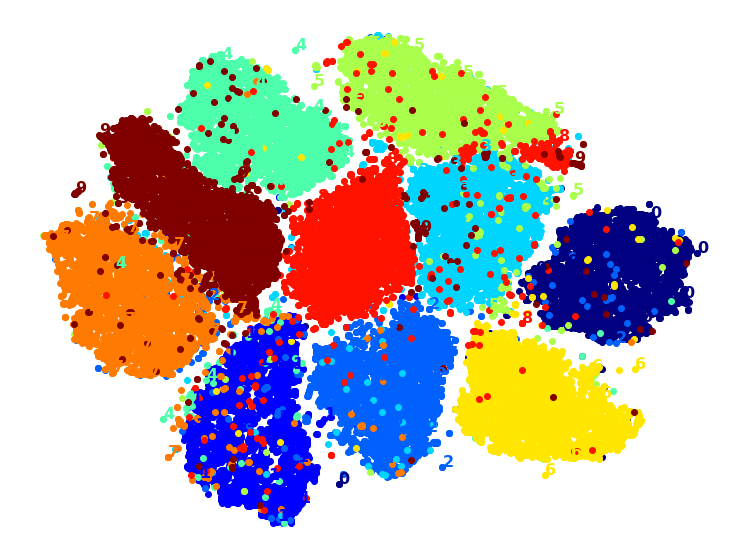

In [61]:
plot_digits(X_tsne_reduced, y_train)

#### PCA with t-SNE:
 - An advantage of PCA is that it can be used in applied with other dimensionality algorithms. As the t-SNE algorithm above showed, it took over 3500 seconds. The visualization below shows while the features were reduced to 154 components, the shape of the clusters were still preserved similar to the previous model, with a reduction in time of over 50%.  

In [138]:
pca_tsne = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=1)),
    ('tsne', TSNE(n_components=2, random_state=1)),
])
start = timer()
X_pca_tsne_reduced = pca_tsne.fit_transform(X_train)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 1498.4643453999997


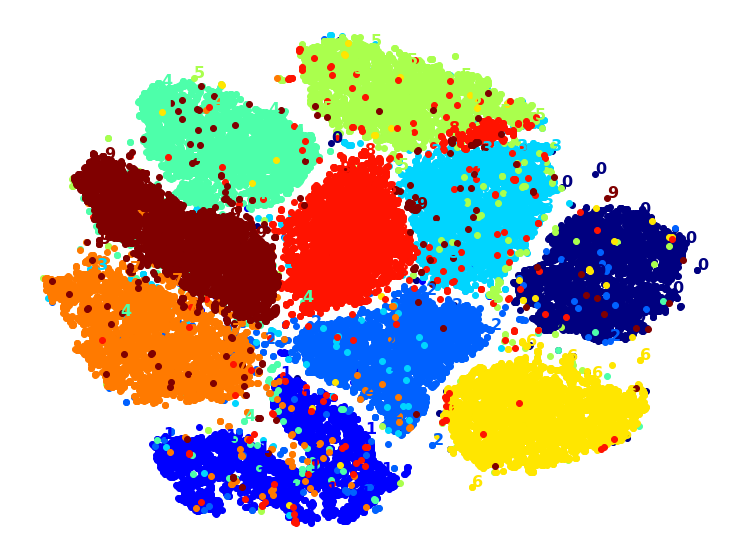

In [139]:
plot_digits(X_pca_tsne_reduced, y_train)

#### LLE (Local Linear Embedding):
 - For performance and time consideration, images were reduced to 10,000, which also gave better visibility on clusters.
 - LLE works by first measuring how each training instance linearly relates to its closest neighbors, and then looks for a low-dimensional representation of the training set where the local relationships are best preserved [2]. This makes it particularly good at unrolling twisted manifolds.
 - Results do not look as good as t-SNE, however they seem to be a little better than PCA.

In [54]:
# Reducing down to 10,000 images
np.random.seed(42)
m = 10000
idx = np.random.permutation(42000)[:m]
X = X_train[idx]
y = y_train[idx]

In [58]:

start = timer()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=1).fit_transform(X)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 168.8458111


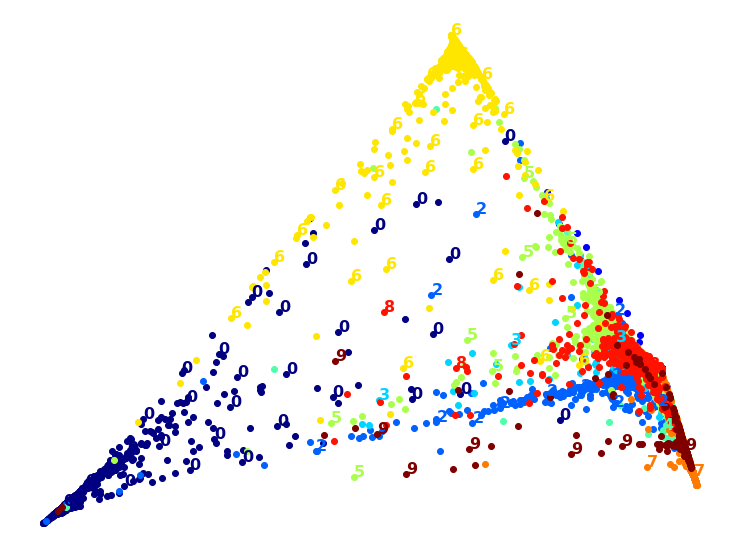

In [59]:
plot_digits(X_lle_reduced, y)

#### PCA with LLE (Local Linear Embedding):
 - PCA applied with LLE is significantly faster. It ran from a little over 2 minutes to less than a minute while preserving the shape of the data. 

In [55]:

pca_lle = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=1)),
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=1)),
])
start = timer()
X_pca_lle_reduced = pca_lle.fit_transform(X)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 51.419257199999265


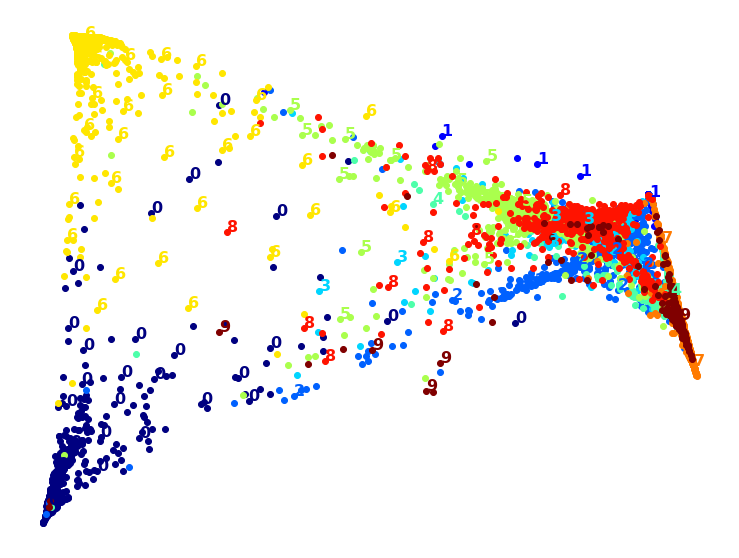

In [57]:
plot_digits(X_pca_lle_reduced, y)

#### MDS (MultiDimensional Scaling):
 - For performance and time consideration, images were reduced to 2,000.
 - MultiDimensional Scaling (MDS) reduces dimensionality while trying to preserve the distances between the instances.
 - MDS is used to translate "information about the pairwise 'distances' among a set of n objects or individuals" into a configuration of n points mapped into an abstract Cartesian space.
 - More technically, MDS refers to a set of related ordination techniques used in information visualization, in particular to display the information contained in a distance matrix. 
 - It is a form of non-linear dimensionality reduction. 
 - The visualization shows that there is significant overlap between the clusters.

In [62]:

n = 2000
start = timer()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:n])
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 174.1097269999991


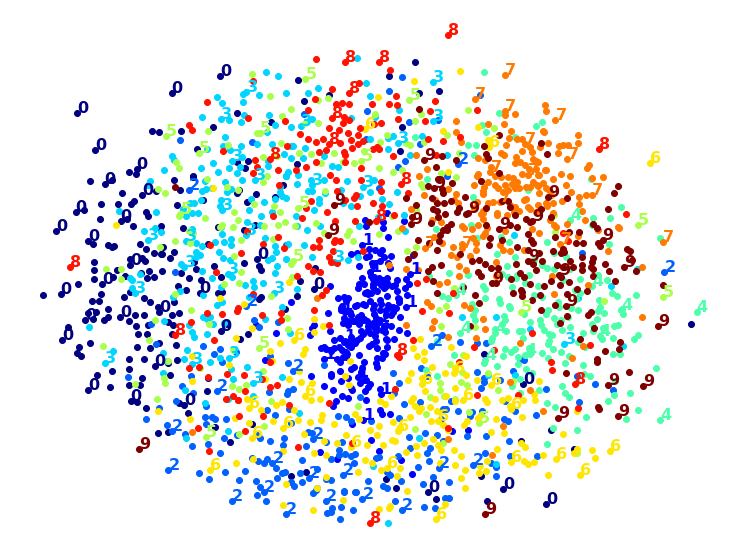

In [67]:
plot_digits(X_mds_reduced, y[:2000])

#### PCA with MDS (MultiDimensional Scaling):
 - Applying PCA does not show an improvement in execution time.

In [65]:
pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
start = timer()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 174.22099359999993


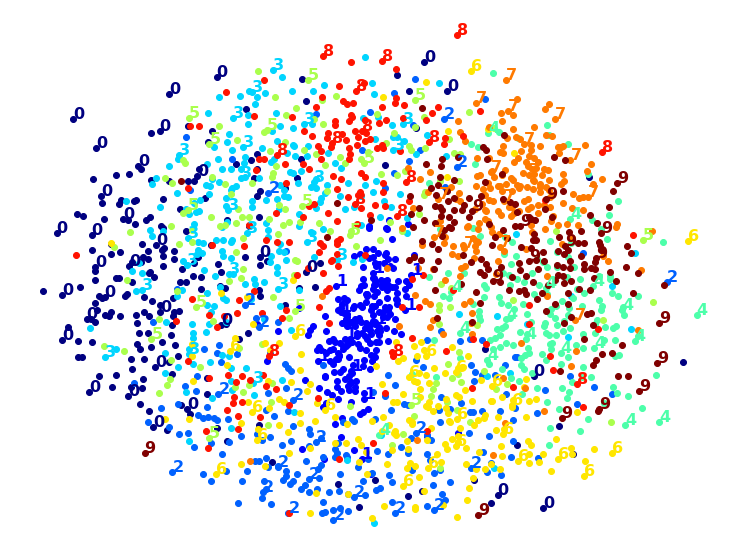

In [66]:
plot_digits(X_pca_mds_reduced, y[:2000])

#### Kernal PCA:
 - Kernel principal component analysis is an extension of principal component analysis (PCA) using techniques of kernel methods. Using a kernel, the originally linear operations of PCA are performed; however can enable non linear classification.
 - The visualization below shows that kernal PCA did perform as well as the others. This may be an indication that the hyperparameter need to be tweaked, which can be done by using it in complement with a supervised learning algorithm.

In [76]:

start = timer()
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced_rbf = rbf_pca.fit_transform(X)
end = timer()
execution_time = (end-start)
print('Execution Time in Seconds:', execution_time)

Execution Time in Seconds: 13.556088199999067


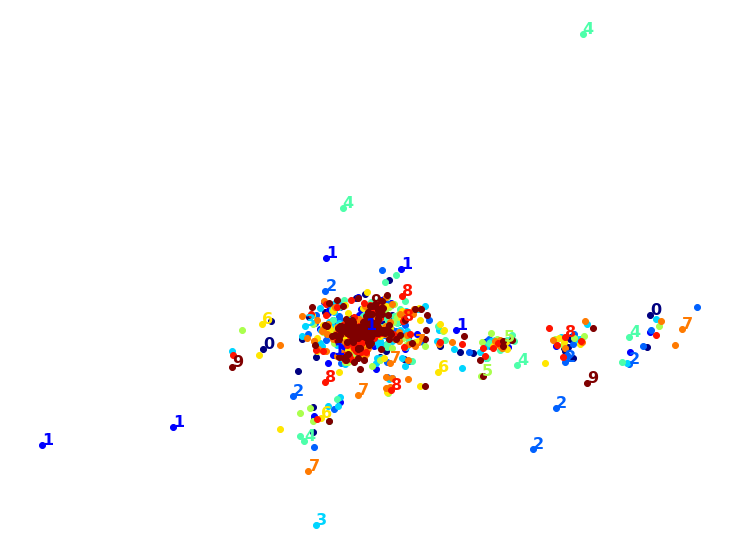

In [77]:
plot_digits(X_reduced_rbf, y)

### Conclusion on Other Dimensionality Reduction Methods:
 - Other dimensionality reduction methods show that there are other ways in dealing with reducing the feature space to help the performance of supervised learning algorithms. 
 - With regards to visualization t-SNE performed the best. However, the algorithm cannot be used on test data, which is a major drawback.
 - There are many other methods that have not been addressed in this analysis. Future exploration is recommended.

### References:
[1] Géron, A. (2017). Hands-on machine learning with Scikit-Learn & TensorFlow: Concepts, tools, and techniques to build intelligent systems. Sebastopol, CA: O’Reilly. 

[2] Müller, A. C., & Guido, S. (2017). Introduction to machine learning with Python: A guide for data scientists. Sebastopol, CA: O’Reilly.

[3] Manning, C. D., Raghaven, P., & Schutze, H. (2008). Introduction to information retrieval. Cambridge, UK: Cambridge University Press.